CW_Folder_UG/Code/SIFT_MLP.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'Personal_Dataset', 'Models', 'CW_Dataset', 'test_functions.ipynb']


Copying and unzipping the dataset zip file for faster reading (from Lab 7)


In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

In [ ]:
# loading files taken from https://stackoverflow.com/questions/273192/how-can-i-safely-create-a-directory-possibly-including-intermediate-directories
from pathlib import Path
import shutil
import os

def dataFolder(trainImagePath, testImagePath):
  Path("./Data").mkdir(parents=True, exist_ok=True)
  Path("./Data/train").mkdir(parents=True, exist_ok=True)
  Path("./Data/test").mkdir(parents=True, exist_ok=True)

  # Creating folders for all labels (0-not wearing mask, 1-wearing mask properly, 2- wearing mask inproperly)
  for n in range(3):
    Path(f"./Data/train/{n}").mkdir(parents=True, exist_ok=True)
    Path(f"./Data/test/{n}").mkdir(parents=True, exist_ok=True)

  # Initialisng train and test path
  trainPath = './Data/train'
  testPath = './Data/test'

 # Reading the text file names and the number within the text file in train folder to match with the name of the image
  file_names = [file for file in os.listdir(trainImagePath) if file.endswith('.jpeg')]
  print(file_names)
  label_files = os.listdir('./train/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./train/labels/' + x, "r").read().strip() for x in label_files}
  # Putting the images into assigned folders for train folder
  for file in file_names:
    shutil.copy(f"{trainImagePath}/{file}", f"{trainPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

 # Reading the text file names and the number within the text file in test folder to match with the name of the image
  file_names = [file for file in os.listdir(testImagePath) if file.endswith('.jpeg')]
  label_files = os.listdir('./test/labels')
  parsed_data = {x.removesuffix(".txt") + ".jpeg":open('./test/labels/' + x, "r").read().strip() for x in label_files} 
  # Putting the images into assigned folders for test folder
  for file in file_names:
    shutil.copy(f"{testImagePath}/{file}", f"{testPath}/{parsed_data[file.replace('_aligned', '')]}/{file}")

In [ ]:
# Loading the folders
dataFolder('./train/images', './test/images')

['image_0963.jpeg', 'image_0479.jpeg', 'image_0345.jpeg', 'image_0336.jpeg', 'image_2237.jpeg', 'image_0019.jpeg', 'image_2156.jpeg', 'image_2326.jpeg', 'image_0338.jpeg', 'image_0944.jpeg', 'image_1159.jpeg', 'image_1409.jpeg', 'image_0716.jpeg', 'image_1392.jpeg', 'image_1575.jpeg', 'image_0515.jpeg', 'image_0147.jpeg', 'image_2374.jpeg', 'image_0450.jpeg', 'image_1842.jpeg', 'image_2025.jpeg', 'image_2100.jpeg', 'image_0745.jpeg', 'image_0306.jpeg', 'image_0591.jpeg', 'image_2131.jpeg', 'image_1993.jpeg', 'image_1404.jpeg', 'image_2310.jpeg', 'image_2161.jpeg', 'image_0391.jpeg', 'image_0376.jpeg', 'image_1758.jpeg', 'image_1405.jpeg', 'image_1086.jpeg', 'image_0136.jpeg', 'image_0196.jpeg', 'image_0576.jpeg', 'image_0114.jpeg', 'image_2388.jpeg', 'image_0446.jpeg', 'image_0931.jpeg', 'image_0259.jpeg', 'image_0667.jpeg', 'image_0906.jpeg', 'image_1374.jpeg', 'image_1904.jpeg', 'image_1142.jpeg', 'image_1433.jpeg', 'image_0521.jpeg', 'image_1115.jpeg', 'image_0611.jpeg', 'image_0799

Importing libraries from lab 7

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import exposure
from sklearn.utils import shuffle

from sklearn.neural_network import MLPClassifier
from joblib import dump, load

from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV

%matplotlib inline



Defining a function to load images and the respective labels, also allowing the subset of classes (From lab 7)

In [ ]:
def import_selected_data(path, label_list):
    """Load images and labels from selected directories"""
    images = []
    labels = []

    if label_list is None:
        folder_names = [folder for folder in sorted(os.listdir(path)) if not folder.startswith('.')]
    else:
        folder_names = [folder for folder in sorted(os.listdir(path)) if folder in label_list]

    for folder in folder_names:
        file_names = [file for file in sorted(os.listdir(os.path.join(path, folder))) if file.endswith('.jpeg')]
        for file in file_names:
            images.append(io.imread(os.path.join(path, folder, file)))
            labels.append(folder)

    return images, labels

Using function to import the data and seeing distribution (from Lab 7)

In [ ]:
#loading the images into X and y 
X, y = import_selected_data('Data/train', label_list=['0', '1', '2'])

In [ ]:
# Sampling distribution via Counter (from lab 7)
print(Counter(y))

Counter({'1': 1940, '0': 376, '2': 78})


As the distribution varies across the labels (numbers) to prevent biases rebalancing is made

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y)

Using SIFT to do intresest point detection and feature descriptors extraction. (from lab 7)

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

# Identify keypoints and extract descriptors with SIFT
for i in range(len(X_train)):
  img = img_as_ubyte(color.rgb2gray(X_train[i]))
  kp, des = sift.detectAndCompute(img, None)

  # Append list of descriptors and label to respective lists
  if des is not None:
      des_list.append(des)
      y_train_list.append(y_train[i])

# Convert to array for easier handling
des_array = np.vstack(des_list)

Clustering of the descriptors via K-means (from lab 7)

In [ ]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

# Using K-means
#kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(des_array)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating histograms of codewords, one from each image. Then plotting the graph. (from lab 7) 

In [ ]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

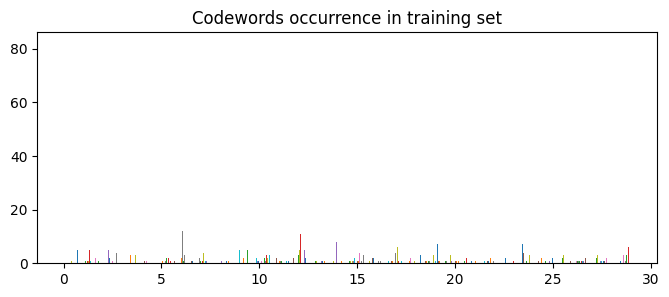

In [ ]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

Training the classifier via MLP - Multi-Layer Perceptron  (from lab 7 and link adapted provided https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html)

In [ ]:
# Compare activations, learning rates, layers
classifier = MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=100, alpha=1e-4,
                    solver='adam', verbose=True, random_state=1,
                    learning_rate_init=.01)

Implementing grid search to find the optimal hyper parameters (from https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa )

In [ ]:
# Defining params to for MLP
params = {
    'hidden_layer_sizes': [(10,30,7),(50,100),(100,0), (150,0)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'], 
    }
clf = GridSearchCV(classifier, params, n_jobs=-1, cv=1)
#clf.fit(hist_array, hist_list)

In [ ]:
classifier.fit(hist_array, y_train_list)
#classifier.fit(X_train, y_train) -----(from MLP lab 7 doesnt work)

Iteration 1, loss = 0.75390287
Iteration 2, loss = 0.56506267
Iteration 3, loss = 0.54199327
Iteration 4, loss = 0.52497679
Iteration 5, loss = 0.50848820
Iteration 6, loss = 0.49515764
Iteration 7, loss = 0.48852370
Iteration 8, loss = 0.48607635
Iteration 9, loss = 0.47985454
Iteration 10, loss = 0.46826475
Iteration 11, loss = 0.46174717
Iteration 12, loss = 0.45424973
Iteration 13, loss = 0.44596664
Iteration 14, loss = 0.43492613
Iteration 15, loss = 0.42859805
Iteration 16, loss = 0.41674716
Iteration 17, loss = 0.40989989
Iteration 18, loss = 0.40434111
Iteration 19, loss = 0.40496093
Iteration 20, loss = 0.40412764
Iteration 21, loss = 0.39481121
Iteration 22, loss = 0.38649710
Iteration 23, loss = 0.38282863
Iteration 24, loss = 0.37771325
Iteration 25, loss = 0.36644035
Iteration 26, loss = 0.35241049
Iteration 27, loss = 0.35014255
Iteration 28, loss = 0.35711952
Iteration 29, loss = 0.33718983
Iteration 30, loss = 0.32846058
Iteration 31, loss = 0.32296411
Iteration 32, los

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50, 100), learning_rate_init=0.01,
              max_iter=100, random_state=1, verbose=True)

Moving to the test set and estimating the accuracy of the model by detecting interest points, extracting feature descriptors and associating histograms of codewords from each image of the test set (from lab 7)

In [ ]:
hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
# Using the classifier to predict the classes of each image
y_pred = classifier.predict(hist_array).tolist()

# y_pred = classifier.predict(X_test) -----(from MLP lab 7 doesnt work)

Comparing the ground-truth labels and predicted classes on images (From lab 7)

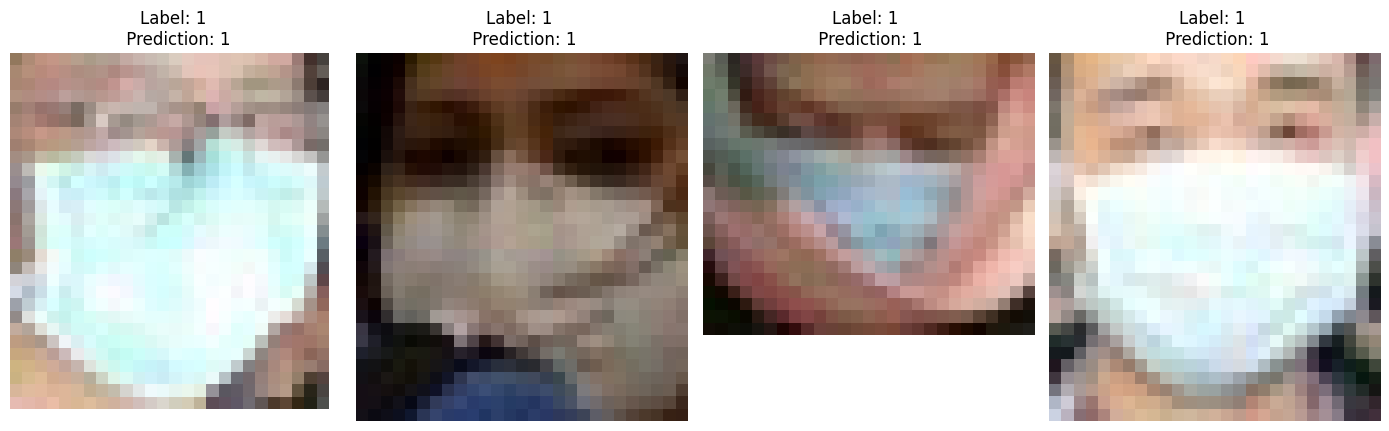

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(4):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
print(f"""Classification report for classifier {classifier}:\n
      {metrics.classification_report(y_test, y_pred)}""")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(50, 100), learning_rate_init=0.01,
              max_iter=100, random_state=1, verbose=True):

                    precision    recall  f1-score   support

           0       0.35      0.35      0.35        75
           1       0.85      0.89      0.87       385
           2       0.50      0.06      0.11        16

    accuracy                           0.77       476
   macro avg       0.57      0.43      0.44       476
weighted avg       0.76      0.77      0.76       476



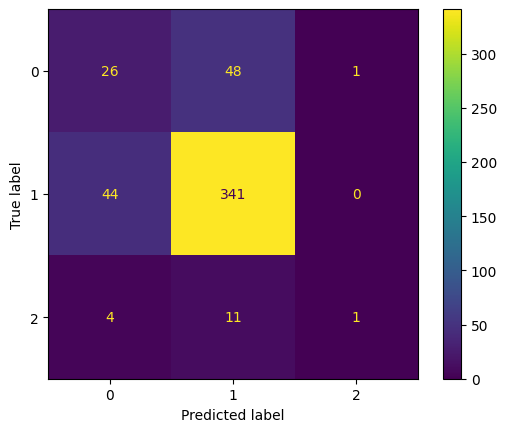

In [ ]:
# Plotting the confusion matrix (From lab 7)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [ ]:
# Saving the model into the Model folder (from lab 7)
dump(classifier, os.path.join(GOOGLE_DRIVE_PATH, 'Models/SIFT_MLP.joblib'))

['drive/My Drive/Colab Notebooks/CW_Folder_UG/Models/SIFT_MLP.joblib']